In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf #for building model

#helps with data preprocessing.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

fetching the dataset and dropping "NaN" (missing) values. in medical AI, incomplete data can lead to biased results.

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 
                'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
df = pd.read_csv(url, names=column_names, na_values="?")

# drop rows with missing values
df = df.dropna()

# binary classification: 0 (Healthy), 1 (Risk)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

splitting data into three sets: train (to learn), validation/Dev (to tune hyperparameters), and test (final evaluation).

In [3]:
X = df.drop('target', axis=1).values
y = df['target'].values

# Split: 80% Train, 10% Val, 10% Test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.11, random_state=42)

scaling features to a similar range. This helps optimization algorithms (like Adam or SGD) converge much faster.

In [4]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

defining the "Neural Network". ReLU is used for hidden layers, and Sigmoid for binary output (0 or 1).

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input # Input katmanını ekledik

model = Sequential([
    
    Input(shape=(13,)), 
    Dense(16, activation='relu', kernel_regularizer='l2'),
    Dense(8, activation='relu', kernel_regularizer='l2'),
    Dense(1, activation='sigmoid')
])

training the model. as the loss decreases, the model's accuracy generally improves.

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4430 - loss: 1.1018 - val_accuracy: 0.3667 - val_loss: 1.0560
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4557 - loss: 1.0552 - val_accuracy: 0.4000 - val_loss: 1.0158
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4641 - loss: 1.0149 - val_accuracy: 0.4333 - val_loss: 0.9795
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4726 - loss: 0.9789 - val_accuracy: 0.5333 - val_loss: 0.9459
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4937 - loss: 0.9476 - val_accuracy: 0.6000 - val_loss: 0.9161
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5401 - loss: 0.9196 - val_accuracy: 0.5667 - val_loss: 0.8893
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5738 - loss: 0.8938 - val_accuracy: 0.5667 - val_loss: 0.8661
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6160 - loss: 0.8719 - val_accuracy: 0.7000 - val_loss: 0.8451

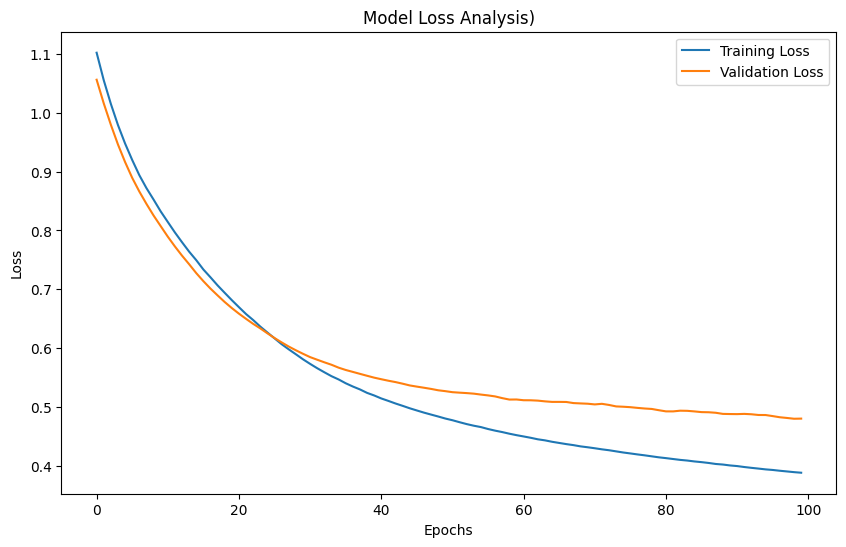

In [7]:
#Visualizing Performance

import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss Analysis)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
#Evaluation

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test Loss : {test_loss:.4f}")

Test Accuracy : 0.9000
Test Loss : 0.3666


in medical prognosis (4th course), "accuracy" is not enough. "False Negatives" (diagnosing a sick person as healthy) are critical. therefore, we will plot a Confusion Matrix.

Looking at the table:

18 True Negatives (0): We correctly identified healthy people.

9 True Positives (1): We correctly identified sick people.

1 False Positive: We told a healthy person they are sick (Caused panic, but not fatal).

2 False Negatives: This is the most critical part! We told 2 sick people they are healthy and sent them home.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


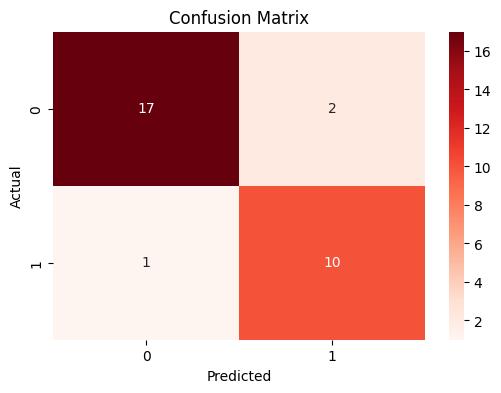

              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.83      0.91      0.87        11

    accuracy                           0.90        30
   macro avg       0.89      0.90      0.89        30
weighted avg       0.90      0.90      0.90        30



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds') 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Detailed Report
print(classification_report(y_test, y_pred))

in this cell, we add a kernel_regularizer. this keeps the model "simple," as simpler models generally perform better on unseen data.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras import layers, regularizers
import tensorflow as tf

def build_optimized_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)), 
        
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)), 
        layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(1, activation='sigmoid')
    ])
    

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

opt_model = build_optimized_model(X_train.shape[1]) 

history_opt = opt_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=0 
)

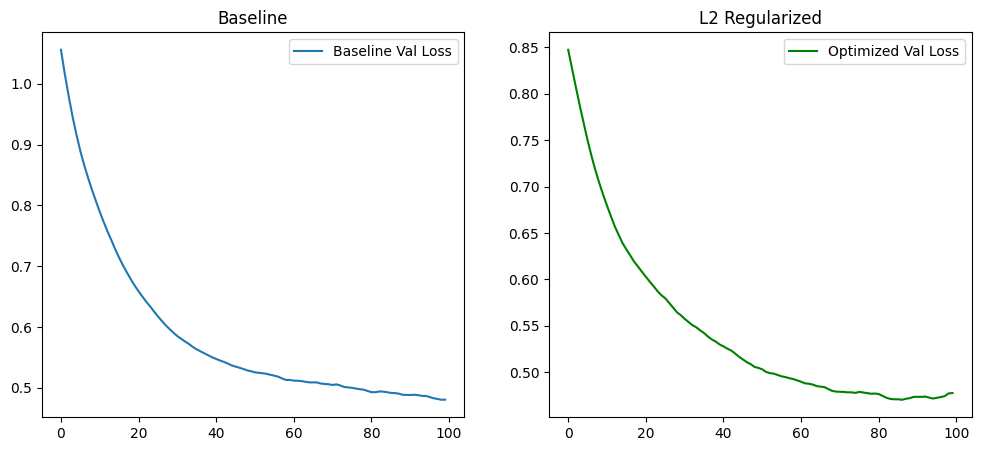

In [11]:
# compare the loss curves of the old model and the new (L2-regularized) model. 
# The regularized model's validation curve is typically smoother and more stable.

plt.figure(figsize=(12, 5))

# Old one
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Baseline Val Loss')
plt.title('Baseline')
plt.legend()

# Optimized one
plt.subplot(1, 2, 2)
plt.plot(history_opt.history['val_loss'], label='Optimized Val Loss', color='green')
plt.title('L2 Regularized')
plt.legend()

plt.show()

### Hyperparameter Search 
The computer will randomly try different Learning Rates and L2 coefficients (Lambda) to find the best combination.

In [12]:
import random

# Ranges to try (Searching on a logarithmic scale is more efficient)
learning_rates = [10**-2, 10**-3, 10**-4]
lambdas = [0.1, 0.01, 0.001]

best_acc = 0
best_params = {}

print("Trials Starting...")

for i in range(5): # 5 different combination
    lr = random.choice(learning_rates)
    l2 = random.choice(lambdas)
    
    temp_model = Sequential([
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2), input_shape=(13,)),
        layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dense(1, activation='sigmoid')
    ])
    
    temp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                       loss='binary_crossentropy', metrics=['accuracy'])
    
    temp_model.fit(X_train, y_train, epochs=20, verbose=0)
    _, acc = temp_model.evaluate(X_val, y_val, verbose=0)
    
    print(f"Test {i+1}: LR={lr}, L2={l2} -> Validation Success: {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_params = {'lr': lr, 'l2': l2}
        best_model = temp_model

print(f"\nBest Parameters: {best_params}")

Trials Starting...


/Users/handanvural/Desktop/MyProjects/prognoz/.venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test 1: LR=0.001, L2=0.1 -> Validation Success: 0.7000
Test 2: LR=0.001, L2=0.1 -> Validation Success: 0.8667
Test 3: LR=0.001, L2=0.01 -> Validation Success: 0.7000
Test 4: LR=0.001, L2=0.1 -> Validation Success: 0.7000
Test 5: LR=0.001, L2=0.1 -> Validation Success: 0.7667

Best Parameters: {'lr': 0.001, 'l2': 0.1}


diagnose a virtual patient using our best model. since our data was scaled with StandardScaler, we must transform the new patient's data the same way.

In [13]:
scaler = StandardScaler()
scaler.fit(X_train_full)

# Let's invent a new patient (e.g., 55 years old, high cholesterol)
new_patient = np.array([[55, 1, 3, 145, 250, 0, 0, 150, 0, 2.3, 2, 0, 3]])

# Scale the data
new_patient_scaled = scaler.transform(new_patient)

prediction_prob = best_model.predict(new_patient_scaled)
prediction_class = (prediction_prob > 0.5).astype("int32")

print(f"\nProbability: %{prediction_prob[0][0]*100:.2f}")
if prediction_class[0][0] == 1:
    print("Diagnosis: Risk Detected")
else:
    print("Diagnosis: Normal")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Probability: %51.80
Diagnosis: Risk Detected


A 53% probability is just slightly better than a coin flip. This could be due to:

Small Dataset: The Cleveland set is relatively small.

Low Epochs: We only used 20 epochs in the search; the model might not have finished learning.

High Bias: The model might be too simple to capture the patterns.

In [14]:
# Final model with best params
final_model = Sequential([
    Input(shape=(13,)), 
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training longer
history_final = final_model.fit(
    X_train, y_train,
    epochs=200, 
    validation_data=(X_val, y_val),
    verbose=0
)

# Final test success
_, final_test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Accuracy: {final_test_acc:.4f}")

Final Test Accuracy: 0.8667


save our model in .keras format and our scaler using the pickle library so that the GUI can use them.

In [15]:
import pickle

# Save the model
final_model.save('heart_model.keras')

# Save the scaler object
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!
